In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
ratings_path = "ml-latest-small/ratings.csv"
ratings = pd.read_csv(ratings_path)

In [3]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
user_mapping = {user_id: idx for idx, user_id in enumerate(ratings['userId'].unique())}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(ratings['movieId'].unique())}

In [5]:
ratings['userId'] = ratings['userId'].map(user_mapping)
ratings['movieId'] = ratings['movieId'].map(movie_mapping)

In [6]:
# Number of users and movies
num_users = len(user_mapping)
num_movies = len(movie_mapping)

In [7]:
num_users

610

In [8]:
num_movies

9724

In [9]:
# Create user-item interaction matrix
full_matrix = torch.zeros((num_users, num_movies))
user_item_matrix = torch.zeros((num_users, num_movies))

In [10]:
for row in ratings.itertuples():
    full_matrix[row.userId, row.movieId] = row.rating

In [11]:
# Convert to PyTorch tensor
user_item_matrix = torch.FloatTensor(user_item_matrix)
full_matrix = torch.FloatTensor(full_matrix)

In [12]:
user_item_matrix.shape

torch.Size([610, 9724])

In [13]:
user_item_matrix

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
full_matrix

tensor([[4.0000, 4.0000, 4.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [2.5000, 2.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.0000, 0.0000, 5.0000,  ..., 3.0000, 3.5000, 3.5000]])

In [15]:
# Split users into train/val and test groups
users = ratings['userId'].unique()
train_val_users, test_users = train_test_split(users, test_size=0.2, random_state=77)

# Create train/val and test dataframes based on the user split
train_val_data = ratings[ratings['userId'].isin(train_val_users)].reset_index(drop=True)
test_data = ratings[ratings['userId'].isin(test_users)].reset_index(drop=True)

In [16]:
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=78)

In [17]:
# Create user-item interaction matrices
train_matrix = torch.zeros((num_users, num_movies))
val_matrix = torch.zeros((num_users, num_movies))
test_matrix = torch.zeros((num_users, num_movies))

# Populate the train matrix
for row in train_data.itertuples():
    train_matrix[row.userId, row.movieId] = row.rating

# Populate the val matrix
for row in val_data.itertuples():
    val_matrix[row.userId, row.movieId] = row.rating

# Populate the test matrix
for row in test_data.itertuples():
    test_matrix[row.userId, row.movieId] = row.rating

In [18]:
train_data.shape

(65712, 4)

In [19]:
test_data.shape

(18696, 4)

In [20]:
val_data.shape

(16428, 4)

In [21]:
train_matrix.shape

torch.Size([610, 9724])

In [22]:
test_matrix.shape

torch.Size([610, 9724])

In [23]:
val_matrix.shape

torch.Size([610, 9724])

In [24]:
class AutoRec(nn.Module):
    def __init__(self, num_items, hidden_dim, lambda_, dropout_prob=0.2):
        super(AutoRec, self).__init__()
        self.lambda_ = lambda_
        self.encoder = nn.Linear(num_items, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, num_items, bias=True)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        encoded = self.sigmoid(self.dropout(self.encoder(x)))
        decoded = self.decoder(encoded)
        return decoded

    def regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += param.norm(2)
        return self.lambda_ * reg_loss

In [25]:
def train_epoch(model, train_data, optimizer, criterion, batch_size):
    model.train()
    num_batches = train_data.size(0) // batch_size
    total_loss = 0

    for i in range(num_batches):
        batch = train_data[i * batch_size:(i + 1) * batch_size].to(device)

        optimizer.zero_grad()
        predictions = model(batch)
        mask = batch > 0 
        # loss = criterion(predictions[mask], batch[mask]) + model.regularization_loss()
        loss = criterion(predictions[mask], batch[mask])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / num_batches


In [26]:
def evaluate_model(model, test_data, criterion, batch_size):
    model.eval()
    num_batches = test_data.size(0) // batch_size
    total_loss = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = test_data[i * batch_size:(i + 1) * batch_size].to(device)

            predictions = model(batch)
            mask = batch > 0  # Mask for non-zero ratings
            loss = criterion(predictions[mask], batch[mask])
            total_loss += loss.item()

    return total_loss / num_batches

In [182]:
# Hyperparameters
hidden_dim = 64
lambda_ = 0.0001
learning_rate = 0.00005
batch_size = 32
epochs = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [183]:
# Initialize model, optimizer, and loss function
model = AutoRec(num_movies, hidden_dim, lambda_).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=5)
criterion = nn.MSELoss()

In [184]:
train_tensor = train_matrix.to(device)
test_tensor = test_matrix.to(device)
val_tensor = val_matrix.to(device)

In [185]:
train_losses, val_losses = [], []

In [186]:
for epoch in range(epochs):
    train_loss = train_epoch(model, train_tensor, optimizer, criterion, batch_size)
    val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step()
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/128, Train Loss: 13.2729, Validation Loss: 13.2264
Epoch 2/128, Train Loss: 13.1541, Validation Loss: 13.1305
Epoch 3/128, Train Loss: 13.0299, Validation Loss: 13.0217
Epoch 4/128, Train Loss: 12.8868, Validation Loss: 12.8962
Epoch 5/128, Train Loss: 12.7201, Validation Loss: 12.7489
Epoch 6/128, Train Loss: 12.5258, Validation Loss: 12.5747
Epoch 7/128, Train Loss: 12.3019, Validation Loss: 12.3875
Epoch 8/128, Train Loss: 12.0609, Validation Loss: 12.1879
Epoch 9/128, Train Loss: 11.8113, Validation Loss: 11.9780
Epoch 10/128, Train Loss: 11.5472, Validation Loss: 11.7598
Epoch 11/128, Train Loss: 11.2824, Validation Loss: 11.5360
Epoch 12/128, Train Loss: 11.0050, Validation Loss: 11.3070
Epoch 13/128, Train Loss: 10.7392, Validation Loss: 11.0764
Epoch 14/128, Train Loss: 10.4723, Validation Loss: 10.8454
Epoch 15/128, Train Loss: 10.2192, Validation Loss: 10.6160
Epoch 16/128, Train Loss: 9.9454, Validation Loss: 10.3879
Epoch 17/128, Train Loss: 9.6995, Validation Loss:

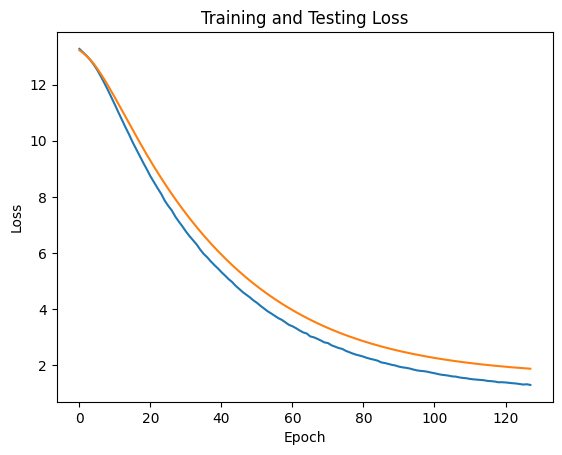

In [187]:
# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.show()

In [188]:
def calculate_rmse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return np.sqrt(mse / total_ratings)

In [189]:
rmse = calculate_rmse(model, test_tensor, batch_size)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 1.4153


In [190]:
import numpy as np
import torch
from torch import nn

# Calculate RMSE
def calculate_rmse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return np.sqrt(mse / total_ratings)

# Calculate MAE
def calculate_mae(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mae = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mae += (predictions[mask] - batch[mask]).abs().sum().item()
            total_ratings += mask.sum().item()

    return mae / total_ratings

# Calculate MSE
def calculate_mse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return mse / total_ratings

# Calculate R-Squared
def calculate_r2(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    ss_total = 0
    ss_residual = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0

            mean_rating = batch[mask].mean().item()
            ss_total += ((batch[mask] - mean_rating) ** 2).sum().item()
            ss_residual += ((predictions[mask] - batch[mask]) ** 2).sum().item()

    return 1 - (ss_residual / ss_total)

# Calculate Explained Variance
def calculate_explained_variance(model, data, batch_size):
    model.eval()
    variance_explained = 0
    variance_total = 0

    with torch.no_grad():
        for i in range(data.size(0) // batch_size):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0

            batch_var = ((batch[mask] - batch[mask].mean()) ** 2).sum().item()
            residual_var = ((batch[mask] - predictions[mask]) ** 2).sum().item()

            variance_total += batch_var
            variance_explained += (batch_var - residual_var)

    return variance_explained / variance_total

batch_size = 32

rmse = calculate_rmse(model, test_tensor, batch_size)
mae = calculate_mae(model, test_tensor, batch_size)
mse = calculate_mse(model, test_tensor, batch_size)
r2 = calculate_r2(model, test_tensor, batch_size)
explained_variance = calculate_explained_variance(model, test_tensor, batch_size)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")
print(f"Test Explained Variance: {explained_variance:.4f}")


Test RMSE: 1.4153
Test MAE: 1.0109
Test MSE: 2.0030
Test R2: -0.9787
Test Explained Variance: -0.9787


In [191]:
# Populate user_item_matrix with ratings from the dataset
for row in ratings.itertuples():
    user_item_matrix[row.userId, row.movieId] = row.rating

In [192]:
def test_model_top_k_masking_with_users(model, test_users, test_matrix, k=5):
    all_metrics = []
    for user_id in test_users:
        metrics = test_model_top_k_masking_single_user_with_test_matrix(
            model, user_id, test_matrix, k=k
        )
        all_metrics.append(metrics)

    avg_accuracy = sum(m["Accuracy"] for m in all_metrics) / len(all_metrics)

    return {
        "Average Accuracy": avg_accuracy,
        "Total Users": len(all_metrics),
    }

In [193]:
def test_model_top_k_masking_single_user_with_test_matrix(model, user_id, test_matrix, k=5):
    model.eval()

    # Get the user index from the mapping
    if user_id not in user_mapping:
        raise ValueError(f"User ID {user_id} not found in user mapping.")

    user_idx = user_mapping[user_id]
    
    # Get the user's ratings from the test matrix
    user_ratings = test_matrix[user_idx].clone()
    
    # Identify the top-K movies rated by the user
    sorted_indices = torch.argsort(user_ratings, descending=True)
    top_k_indices = sorted_indices[:k]
    
    # Save the actual values for the top-K movies
    real_values = user_ratings[top_k_indices].tolist()
    
    # Mask the top-K ratings in the matrix
    masked_ratings = user_ratings.clone()
    masked_ratings[top_k_indices] = 0  # Set top-K ratings to 0 for prediction

    # Predict ratings for all movies
    predicted_ratings = model(masked_ratings.unsqueeze(0).to(device)).squeeze(0).cpu()
    
    # Retrieve predictions for the masked movies
    predicted_values = predicted_ratings[top_k_indices].tolist()

    # Calculate hits (correct predictions)
    threshold = min(real_values)  # Use the lowest rating among the top-K as the threshold
    predicted_set = torch.argsort(predicted_ratings, descending=True)[:k].tolist()
    hits = sum(1 for idx in top_k_indices if idx in predicted_set)
    accuracy = hits / k

    # Compute evaluation metrics
    rmse = torch.sqrt(torch.mean((torch.tensor(predicted_values) - torch.tensor(real_values)) ** 2)).item()
    mae = torch.mean(torch.abs(torch.tensor(predicted_values) - torch.tensor(real_values))).item()

    return {
        "Accuracy": accuracy * 100,  # Convert to percentage
        "Hits": hits,
        "Total Masked": k,
    }

In [194]:
# Evaluate the model on the test users
metrics = test_model_top_k_masking_with_users(model, test_users, test_matrix, k=50)

# Print the results
print(f"Average Accuracy: {metrics['Average Accuracy']:.2f}%")
print(f"Total Test Users: {metrics['Total Users']}")

Average Accuracy: 12.26%
Total Test Users: 122


# Choosing hyperparameters

Best Hyperparameters: {'hidden_dim': 100, 'lambda_': 0.0001, 'learning_rate': 0.01, 'batch_size': 32, 'amsgrad': False}

Best RMSE: 1.1672

However, it is for little amount of epochs, so this only gives us some basis for hyperparameters.


In [40]:
# import itertools
# from sklearn.model_selection import KFold
# import numpy as np
# import torch
# from torch import nn

# # Define hyperparameter grid
# param_grid = {
#     'hidden_dim': [100, 500, 1000],
#     'lambda_': [0.0001, 0.001],
#     'learning_rate': [0.01, 0.015, 0.001, 0.0001],
#     'batch_size': [32, 64, 128, 256],
#     'amsgrad': [False, True],
# }

# param_combinations = list(itertools.product(*param_grid.values()))

# # Define K-Fold Cross-Validation
# k_folds = 5
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# # Function to train and evaluate using K-Fold Cross-Validation
# def train_and_evaluate_kfold(params, full_matrix, k_folds):
#     # Unpack parameters
#     hidden_dim, lambda_, learning_rate, batch_size, amsgrad = params

#     # Initialize storage for RMSE scores
#     fold_rmse_scores = []

#     # Perform K-Fold Cross-Validation
#     for train_idx, val_idx in kf.split(full_matrix):
#         # Create train and validation matrices
#         train_matrix = torch.zeros_like(full_matrix)
#         val_matrix = torch.zeros_like(full_matrix)
        
#         # Populate train and validation matrices
#         train_matrix[train_idx] = full_matrix[train_idx]
#         val_matrix[val_idx] = full_matrix[val_idx]
        
#         # Initialize model, optimizer, and loss function
#         model = AutoRec(num_movies, hidden_dim, lambda_).to(device)
#         optimizer = torch.optim.Adam(
#             model.parameters(),
#             lr=learning_rate,
#             amsgrad=amsgrad
#         )
#         criterion = nn.MSELoss()

#         # Add a scheduler to dynamically adjust learning rate
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#             optimizer, mode='min', factor=0.25, patience=2, verbose=False
#         )

#         # Train the model
#         train_tensor = train_matrix.to(device)
#         val_tensor = val_matrix.to(device)
#         for epoch in range(10):  # Fewer epochs for faster cross-validation
#             train_epoch(model, train_tensor, optimizer, criterion, batch_size)

#             # Evaluate the model on the validation set after each epoch
#             val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

#             # Step the scheduler with validation loss
#             scheduler.step(val_loss)

#         # Final evaluation for this fold
#         rmse = calculate_rmse(model, val_tensor, batch_size)
#         fold_rmse_scores.append(rmse)

#     # Return the average RMSE across all folds
#     return np.mean(fold_rmse_scores)

# # Track best hyperparameters and performance
# best_params = None
# best_rmse = float('inf')

# # Perform hyperparameter search
# for i, params in enumerate(param_combinations):
#     print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
#     rmse = train_and_evaluate_kfold(params, full_matrix, k_folds)

#     print(f"Average RMSE across {k_folds} folds: {rmse:.4f}")

#     # Update best parameters if current RMSE is better
#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_params = params

# # Print the best hyperparameters
# best_param_dict = dict(zip(param_grid.keys(), best_params))
# print(f"\nBest Hyperparameters: {best_param_dict}")
# print(f"Best RMSE: {best_rmse:.4f}")
